# Astroid Avoidance

## Setup

In [121]:
# Reload scripts when executed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import casadi as ca
import control
from dataclasses import dataclass, field
import numpy as np
import os
import sys
import models.rocketXZModel as rocketXZModel
from IPython.display import HTML
import matplotlib.pyplot as plt

In [123]:
# Fix random seed and print options
np.random.seed(1)
np.set_printoptions(threshold=10000, linewidth=np.inf)

## Define controller

In [124]:
@dataclass
class RocketXZLQRCtrlConfig:
    Q: np.ndarray = field(default_factory=lambda: np.diag([1.0, 1.0, 0.1, 0.1, 1.0, 0.1]))
    R: np.ndarray = field(default_factory=lambda: np.diag([0.1, 0.1]))
    x_equilibrium: np.ndarray = field(default_factory=lambda: np.array([0.3, 2.0, 0.0, 0.0, 0.0, 0.0]))

In [125]:
class RocketXZLQRCtrl:
    def __init__(self, sampling_time: float, model: rocketXZModel.RocketXZModel):
        self._sampling_time = sampling_time
        self._model = model
        self._ctrl_config = RocketXZLQRCtrlConfig()
        self._goal_val = None

        def compute_continuousT_feedback_gain(x_equilibrium: np.ndarray, u_equilibrium: np.ndarray):
            A, B = self._model.linearizeContinuousDynamics(x_equilibrium, u_equilibrium)
            Q = self._ctrl_config.Q
            R = self._ctrl_config.R
            K, S, E = control.lqr(A, B, Q, R)
            return K

        def compute_discreteT_feedback_gain(x_equilibrium: np.ndarray, u_equilibrium: np.ndarray):
            A, B = self._model.linearizeDiscreteDynamics(x_equilibrium, u_equilibrium)
            Q = self._ctrl_config.Q
            R = self._ctrl_config.R
            K, S, E = control.dlqr(A, B, Q, R)
            return K

        self.u_equilibrium = np.array([-self._model.model_config.mass*self._model.model_config.gravity, 0.0])
        self.fdbk_gain = compute_discreteT_feedback_gain(self._ctrl_config.x_equilibrium, self.u_equilibrium)


    def compute_LQR_control(self, x: np.ndarray,):
        x_error = x - self._ctrl_config.x_equilibrium
        u = self.u_equilibrium - self.fdbk_gain @ x_error
        return u

    @property
    def x_equilibrium(self):
        return self._ctrl_config.x_equilibrium

    

Step 1: x = [ 0.00832676  1.00308253  0.33464975  0.12243689 -0.01546945 -0.61877806], u = [-9.77689733 -0.4945932 ]
Step 2: x = [ 0.02313389  1.0137896   0.26061995  0.30617441 -0.04202761 -0.44354819], u = [-9.49633258  0.13883841]
Step 3: x = [ 0.03491329  1.03296145  0.21253169  0.46084715 -0.06040348 -0.29148682], u = [-9.05760146  0.12624705]
Step 4: x = [ 0.0447429   1.05918267  0.1818088   0.58805972 -0.07162955 -0.15755577], u = [-8.65871147  0.11627015]
Step 5: x = [ 0.05340471  1.09113877  0.16516125  0.6901983  -0.07667072 -0.04409105], u = [-8.30022186  0.10270609]
Step 6: x = [ 0.0615217   1.12763668  0.15950855  0.76971773 -0.07656593  0.04828265], u = [-7.98066461  0.08691956]
Step 7: x = [ 0.0695706   1.16760641  0.16206154  0.82907325 -0.07235406  0.12019202], u = [-7.69806595  0.07011663]
Step 8: x = [ 0.07789746  1.21009941  0.17036236  0.87065682 -0.06502123  0.17312107], u = [-7.45009312  0.05330886]
Step 9: x = [ 0.08673453  1.25428399  0.18229794  0.89674558 -0.

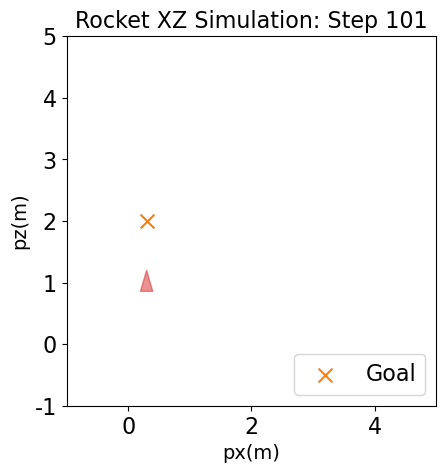

In [ ]:
    sampling_time = 0.05
    sim_length = 100
    x_init = np.array([0., 1.0, 0.0, 0.0, 0., 0.])
    model = rocketXZModel.RocketXZModel(sampling_time)
    controller = RocketXZLQRCtrl(sampling_time, model)
    x_trajectory, u_trajectory, asteroid = model.simulateClosedLoop(sim_length, x_init, controller.compute_LQR_control)
    theta = np.linspace(0, 2 * np.pi, 100)
    asteroid_circle = np.array([
        asteroid[0] + asteroid[2] * np.cos(theta),
        asteroid[1] + asteroid[2] * np.sin(theta)
    ])

    additional_lines_or_scatters = {
        "Goal": {
            "type": "scatter",
            "data": [[controller.x_equilibrium[0]], [controller.x_equilibrium[1]]],
            "color": "tab:orange",
            "s": 100,
            "marker": "x"
        },
        "Asteroid": {
            "type": "line",
            "data": asteroid_circle,
            "color": "tab:red"
        }
    }
    anim = model.animateSimulation(x_trajectory, u_trajectory, additional_lines_or_scatters)
    HTML(anim.to_jshtml())
